# Library

In [1]:
import pandas as pd
import numpy as np
import gzip
import sys
sys.path.append('../../../Util')
import PreProcessingText as ppt
import BERTopicUtils as btu
from llama_cpp import Llama
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired, PartOfSpeech
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan
from bertopic.vectorizers import ClassTfidfTransformer
from transformers import pipeline
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\dommy\miniconda3\envs\gestione\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1° Baseline Summary: Specific Topics (Best Baseline)

### Clustering Approach

- **Parameter Setting**:
  - Embedding Model: all-MiniLM-L6-v2
  - Representation Model: keyBERTInspired, MaximalMarginalRelevance
  - Count Vectorizer
  - CtfIDF
  - UMAP: 150 neighbors, 10 components
  - HDBSCAN: 150 min cluster size
  - Zero-Shot Classification on cluster name
  - Outliers-reduction with Probabilites: 0.075 threshold

### Clustering Results

- **Clusters Retrieved**: 30 in which the most important ones concern:
  1. Socialism
  2. Elections Fraud America
  3. Racism Mexico
  4. Israel War
  5. Elections Europe
  6. Deep State
  7. Trump
  8. Climate Change
  9. White Racism
  10. Coronavirus
  11. Big Tech
  12. Religion


- **Performance Metrics**:
  - **Silhouette Score**: 0.60
  - **Davies-Bouldin Score**: 0.55
  - **Coherence-Score**: 0.46
  - **Dos Score**: 0.2
  - **%Outliers**: 0.32 (16.8k/52.3k)

In [78]:
df = btu.load_data_filtered('../../../Datasets/CleanedData/posts_white_nation_cleaned_content_created_preprocessed.csv', 'content')

52310


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

Using device: cpu


In [ ]:
corpus = df['content'].tolist()
corpus = list(set(corpus))
embeddings = model.encode(corpus, batch_size=64, show_progress_bar=True)

In [ ]:
'''
np.savez_compressed('PreProcessFiles/content_preprocessed_embeddings_white_nation.npz', embeddings)
with gzip.open('PreProcessFiles/content_preprocessed_corpus_white_nation.txt.gz', 'wt') as f:
    for word in corpus:
        f.write(word + '\n')
'''

In [3]:
with np.load('PreProcessFiles/content_preprocessed_embeddings_white_nation.npz') as data:
    embeddings = data['arr_0']

with gzip.open('PreProcessFiles/content_preprocessed_corpus_white_nation.txt.gz', 'rt') as f:
    corpus = f.read().split('\n')

corpus.pop()

''

In [50]:
mmr = MaximalMarginalRelevance(diversity=0.3)
kw = KeyBERTInspired()
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=150, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    nr_topics=32,
    top_n_words=10, 
    n_gram_range=(1, 3),
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model, 
    ctfidf_model=ctfidf_model, 
    representation_model=[mmr, kw],
    embedding_model=model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(corpus, embeddings)

2024-08-01 17:54:21,224 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-01 18:01:28,421 - BERTopic - Dimensionality - Completed ✓
2024-08-01 18:01:28,582 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-01 18:02:14,513 - BERTopic - Cluster - Completed ✓
2024-08-01 18:02:14,544 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-01 18:02:40,518 - BERTopic - Representation - Completed ✓
2024-08-01 18:02:40,526 - BERTopic - Topic reduction - Reducing number of topics
2024-08-01 18:03:01,096 - BERTopic - Topic reduction - Reduced number of topics from 35 to 32


In [51]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 5))
topic_model.update_topics(corpus, vectorizer_model=vectorizer_model)
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  23147                           -1_trump_new_video_state   
1       0  10136  0_socialism_lesson_lesson applied socialism_ap...   
2       1   2106                     1_trump_democrats_pelosi_biden   
3       2   1799                        2_border_illegal_wall_trump   
4       3   1211                        3_israel_syria_iran_israeli   
5       4   1184                          4_brexit_eu_farage_europe   
6       5   1062            5_thread_pictures_pictures thread_funny   
7       6    914            6_climate_climate change_change_warming   
8       7    893                            7_market_fed_bank_banks   
9       8    814        8_sgt_sgt report_report_appeared sgt report   
10      9    802                          9_mueller_fbi_comey_trump   
11     10    768                   10_gun_guns_gun control_shooting   
12     11    683                    11_facebook_google_twitter_tech   
13     12    606                       12_china_trade_chinese_trump   
14     13    605                   13_gold_silver_report_sgt report   
15     14    569             14_epstein_jeffrey epstein_jeffrey_sex   
16     15    461                    15_women_men_transgender_gender   
17     16    458                       16_jews_jewish_jew_holocaust   
18     17    438                  17_kavanaugh_ford_christine_brett   
19     18    410                  18_white_race_white people_racist   
20     19    393           19_youtube_music_favorite_favorite music   
21     20    384            20_vaccine_vaccines_measles_vaccination   
22     21    371                   21_cancer_vitamin_monsanto_study   
23     22    287                 22_america_world_empire_globalists   
24     23    281  23_abortion_planned parenthood_parenthood_planned   
25     24    274      24_christianity_christians_christian_religion   
26     25    266                       25_media_news_fake news_fake   
27     26    221                 26_antifa_portland_police_violence   
28     27    220                 27_college_school_students_schools   
29     28    197            28_stormfront_stormfront sucks_sucks_sf   
30     29    185         29_assange_julian_julian assange_wikileaks   
31     30    165                30_coronavirus_pandemic_virus_wuhan   

                                       Representation  \
0   [trump, new, video, state, president, report, ...   
1   [socialism, lesson, lesson applied socialism, ...   
2   [trump, democrats, pelosi, biden, impeachment,...   
3   [border, illegal, wall, trump, mexico, immigra...   
4   [israel, syria, iran, israeli, trump, war, rus...   
5   [brexit, eu, farage, europe, yellow, merkel, m...   
6   [thread, pictures, pictures thread, funny, kno...   
7   [climate, climate change, change, warming, glo...   
8   [market, fed, bank, banks, global, money, cent...   
9   [sgt, sgt report, report, appeared sgt report,...   
10  [mueller, fbi, comey, trump, investigation, do...   
11  [gun, guns, gun control, shooting, control, po...   
12  [facebook, google, twitter, tech, censorship, ...   
13  [china, trade, chinese, trump, war, tariffs, t...   
14  [gold, silver, report, sgt report, sgt, appear...   
15  [epstein, jeffrey epstein, jeffrey, sex, maxwe...   
16  [women, men, transgender, gender, feminism, fe...   
17  [jews, jewish, jew, holocaust, judaism, white,...   
18  [kavanaugh, ford, christine, brett, brett kava...   
19  [white, race, white people, racist, racism, pe...   
20  [youtube, music, favorite, favorite music, you...   
21  [vaccine, vaccines, measles, vaccination, flu,...   
22  [cancer, vitamin, monsanto, study, cells, glyp...   
23  [america, world, empire, globalists, global, w...   
24  [abortion, planned parenthood, parenthood, pla...   
25  [christianity, christians, christian, religion...   
26  [media, news, fake news, fake, mainstream, mai...   
27  [antifa, portland, police, violence, antifa te...   
28  [co

In [52]:
umap_embeddings = topic_model.umap_model.fit_transform(embeddings)

In [53]:
sihouette_davies_score = btu.calculate_silhouette_davies(umap_embeddings, topics)
coherence_score = btu.evaluate_topic_coherence(topic_model.get_topics(), corpus)
dos_score = btu.calculate_dos(topic_model.get_topics())

Silhouette Score: 0.6501653790473938
Davies-Bouldin Score: 0.44627586887269444
Coherence Model: 0.45521361345129496
Distinta Overlap Score: 0.10685483870967742


In [61]:
new_topics = topic_model.reduce_outliers(corpus, topics, strategy="probabilities", probabilities=probs, threshold=0.075)
topic_model.update_topics(corpus, topics=new_topics)
topic_model.get_topic_info()

2024-08-01 18:19:58,009 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic  Count                                               Name  \
0      -1  16801                                 -1_the_trump_to_of   
1       0  10136     0_socialism_lesson_applied socialism_practical   
2       1   2606                     1_trump_democrats_pelosi_biden   
3       2   1802                        2_border_illegal_wall_trump   
4       3   1740                             3_israel_iran_syria_us   
5       4   1184                          4_brexit_eu_farage_europe   
6       5   1067                           5_thread_re_you_pictures   
7       6    915            6_climate_climate change_change_warming   
8       7   1227                              7_the_fed_market_bank   
9       8    832             8_sgt_sgt report_report_appeared first   
10      9   3596                        9_mueller_fbi_trump_clinton   
11     10    828                   10_gun_guns_gun control_shooting   
12     11    818                    11_facebook_google_tech_twitter   
13     12    642                       12_china_trade_chinese_trump   
14     13    750                     13_gold_silver_report_the post   
15     14    569             14_epstein_jeffrey epstein_jeffrey_sex   
16     15    485                    15_women_men_transgender_gender   
17     16    590                       16_jews_jewish_jew_holocaust   
18     17    442                  17_kavanaugh_ford_christine_brett   
19     18    571                  18_white_racist_white people_race   
20     19    398            19_youtube_music_favorite_what favorite   
21     20    400            20_vaccine_vaccines_measles_vaccination   
22     21    645                     21_cancer_monsanto_pharma_drug   
23     22    332                        22_america_the_world_empire   
24     23    281  23_abortion_planned parenthood_parenthood_planned   
25     24    551          24_christians_christianity_pope_christian   
26     25    662                        25_media_news_cnn_fake news   
27     26    337                 26_antifa_portland_police_violence   
28     27    374                 27_college_school_students_schools   
29     28    197  28_stormfront_stormfront sucks_re stormfront s...   
30     29    192         29_assange_julian_julian assange_wikileaks   
31     30    340             30_coronavirus_virus_pandemic_outbreak   

                                       Representation  \
0    [the, trump, to, of, in, new, is, us, re, video]   
1   [socialism, lesson, applied socialism, practic...   
2   [trump, democrats, pelosi, biden, election, im...   
3   [border, illegal, wall, trump, mexico, immigra...   
4   [israel, iran, syria, us, israeli, trump, war,...   
5   [brexit, eu, farage, europe, yellow, merkel, m...   
6   [thread, re, you, pictures, pictures thread, f...   
7   [climate, climate change, change, warming, glo...   
8   [the, fed, market, bank, banks, global, financ...   
9   [sgt, sgt report, report, appeared first, appe...   
10  [mueller, fbi, trump, clinton, obama, comey, s...   
11  [gun, guns, gun control, shooting, control, po...   
12  [facebook, google, tech, twitter, social media...   
13  [china, trade, chinese, trump, tariffs, us, tr...   
14  [gold, silver, report, the post, sgt report, s...   
15  [epstein, jeffrey epstein, jeffrey, sex, maxwe...   
16  [women, men, transgender, gender, feminism, fe...   
17  [jews, jewish, jew, holocaust, the jews, the, ...   
18  [kavanaugh, ford, christine, brett, brett kava...   
19  [white, racist, white people, race, black, peo...   
20  [youtube, music, favorite, what favorite, what...   
21  [vaccine, vaccines, measles, vaccination, flu,...   
22  [cancer, monsanto, pharma, drug, big pharma, g...   
23  [america, the, world, empire, globalists, of, ...   
24  [abortion, planned parenthood, parenthood, pla...   
25  [christians, christianity, pope, christian, ch...   
26  [media, news, cnn, fake news, fake, mainstream...   
27  [antifa, portland, police, violence, protester...   
28  [co

In [62]:
sihouette_davies_score = btu.calculate_silhouette_davies(umap_embeddings, new_topics)
coherence_score = btu.evaluate_topic_coherence(topic_model.get_topics(), corpus)
dos_score = btu.calculate_dos(topic_model.get_topics())

Silhouette Score: 0.5842010974884033
Davies-Bouldin Score: 0.5458231433725081
Coherence Model: 0.45644951350297375
Distinta Overlap Score: 0.1975806451612903


In [63]:
topic_model.visualize_topics()

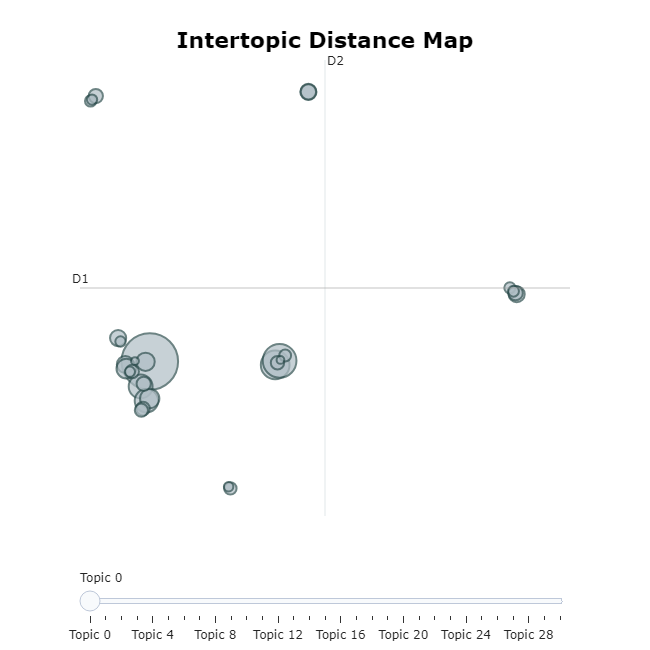

In [64]:
reduced_embeddings = UMAP(n_neighbors=150, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(corpus, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True, custom_labels=True)

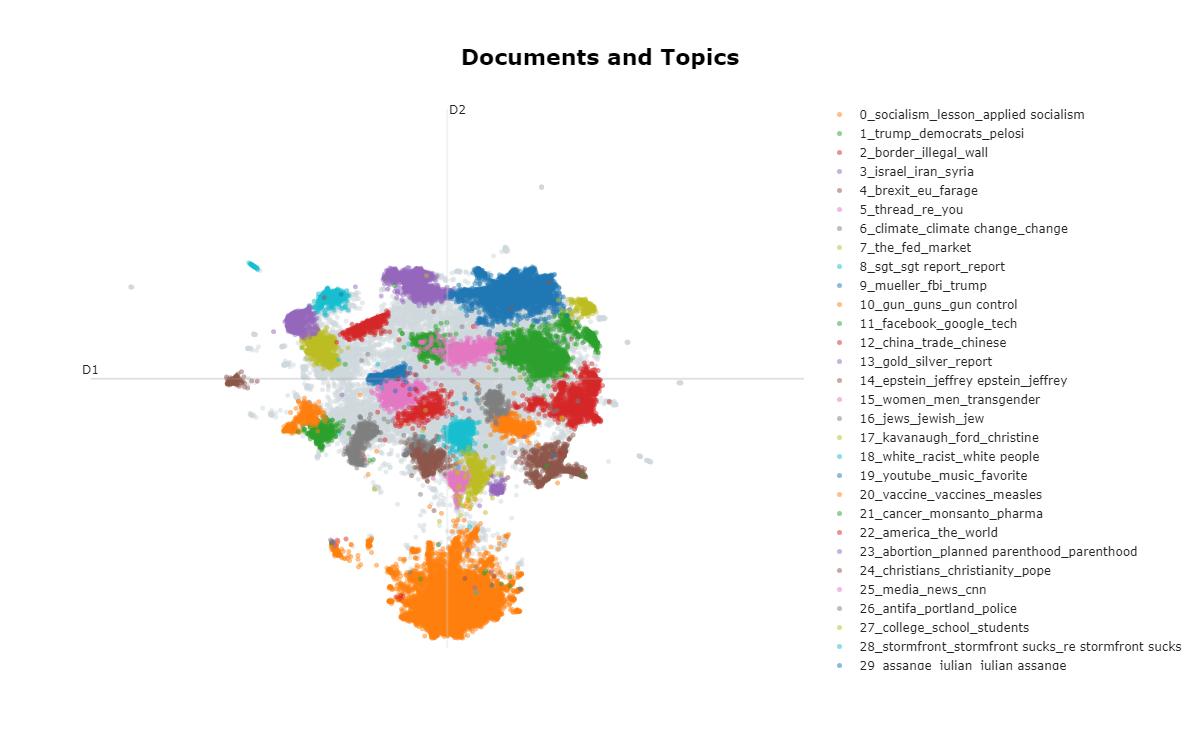

In [65]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [67]:
zero_shot_topics = pd.read_csv('../../../Datasets/IntentCrime/intent_crime.csv')['intent'].tolist()
dict_zero_shots_25 = btu.assign_labels_to_topics(classifier, topic_model, zero_shot_topics, len(set(new_topics) - {-1}), threshold=.25)

Assigning labels to topics: 100%|██████████| 31/31 [29:46<00:00, 57.62s/it]


In [69]:
btu.save_assigned_labels(dict_zero_shots_25, 'ZeroShotClassificationResultsContent/all-MiniLM-L6-v2_150_150n_10dim/zero_shot_025.csv')

In [70]:
topic_model.set_topic_labels(dict_zero_shots_25)

# LLAMA

In [ ]:
# Use llama.cpp to load a Quantized LLM
llm = Llama(model_path="../../../openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=9096, stop=["Q:", "\n"])

In [82]:
topic_names = topic_model.get_topic_info()[['Topic', 'Representation', 'Representative_Docs']]
topic_names = topic_names[topic_names['Topic'] != -1]
topic_label = btu.process_dataset(llm, topic_names)

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]
llama_print_timings:        load time =  111974.51 ms
llama_print_timings:      sample time =      32.11 ms /    14 runs   (    2.29 ms per token,   436.00 tokens per second)
llama_print_timings: prompt eval time =  111965.05 ms /   164 tokens (  682.71 ms per token,     1.46 tokens per second)
llama_print_timings:        eval time =  198602.36 ms /    13 runs   (15277.10 ms per token,     0.07 tokens per second)
llama_print_timings:       total time =  320127.23 ms /   177 tokens
Processing dataset:   3%|▎         | 1/31 [05:20<2:40:20, 320.68s/it]Llama.generate: prefix-match hit

llama_print_timings:        load time =  111974.51 ms
llama_print_timings:      sample time =      31.04 ms /    16 runs   (    1.94 ms per token,   515.46 tokens per second)
llama_print_timings: prompt eval time =   50583.85 ms /   196 tokens (  258.08 ms per token,     3.87 tokens per second)
llama_print_timings:        eval time =   23459.29 ms / 

In [131]:
#topic_label.to_csv('LLAMA/topic_model_all_MiniLM-L6-v2_150_150n_10dim_LLAMA_results_white_nation.csv', index=False)
new_topics = pd.read_csv('LLAMA/topic_model_all_MiniLM-L6-v2_150_150n_10dim_LLAMA_results_white_nation.csv')

In [132]:
topic_model.set_topic_labels(new_topics.set_index('Topic')['Label'].to_dict())

In [133]:
topic_model.visualize_barchart(top_n_topics=35, n_words=10, width=350, height=350, custom_labels=True)

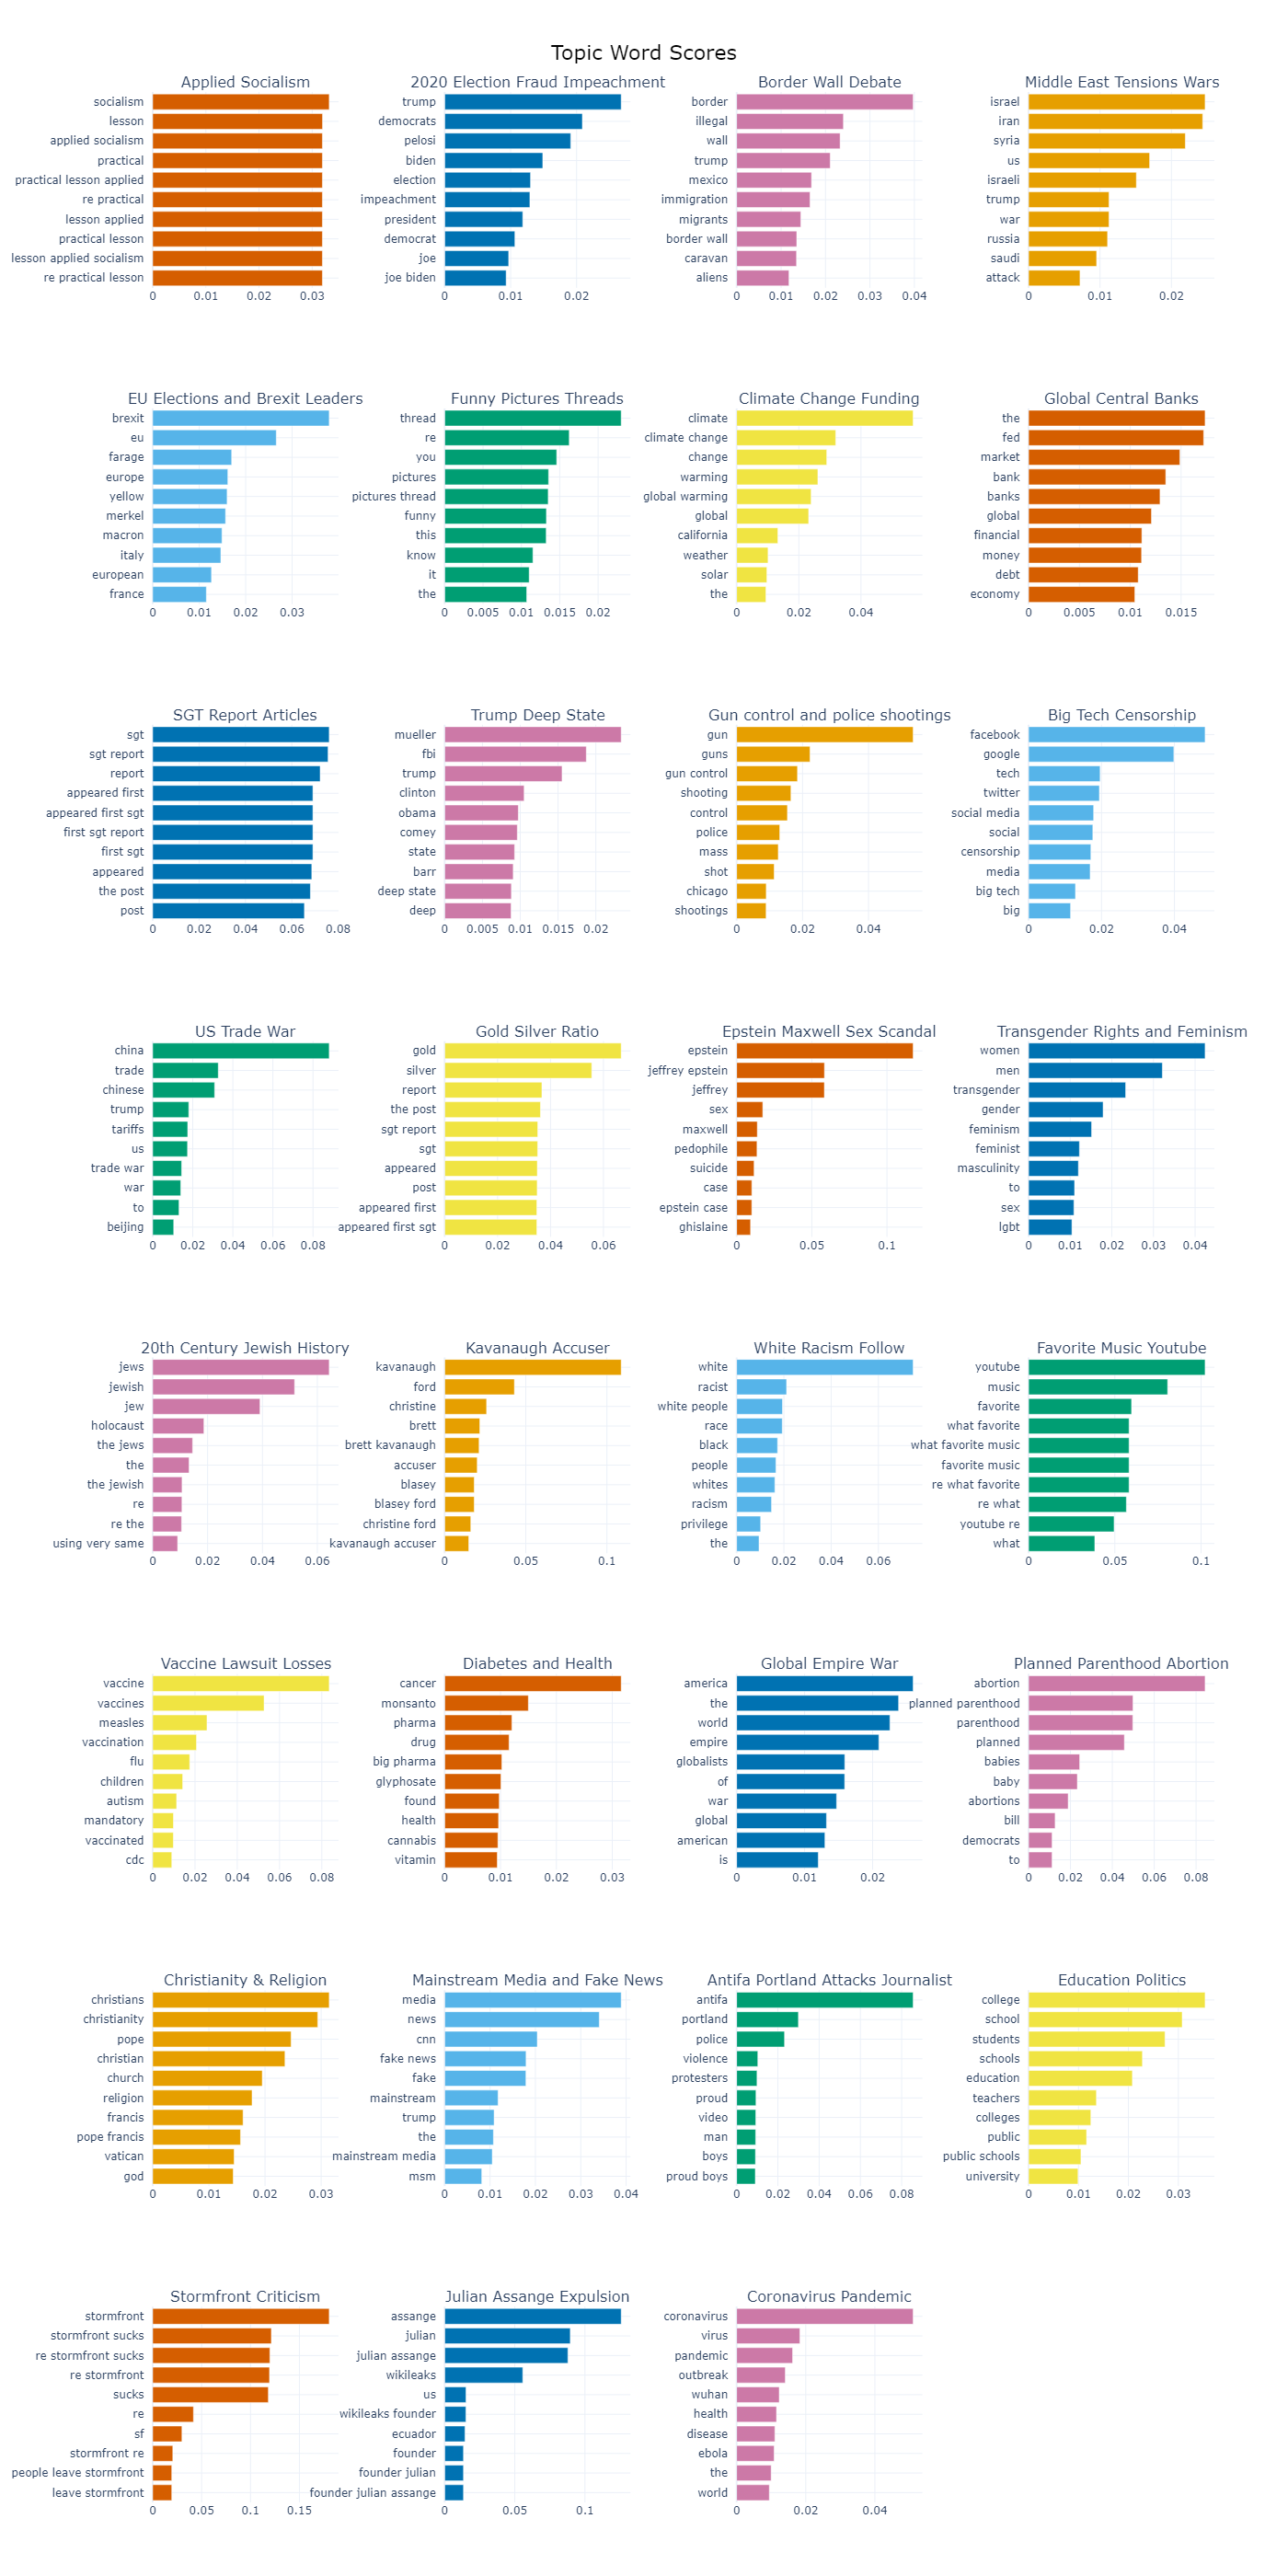
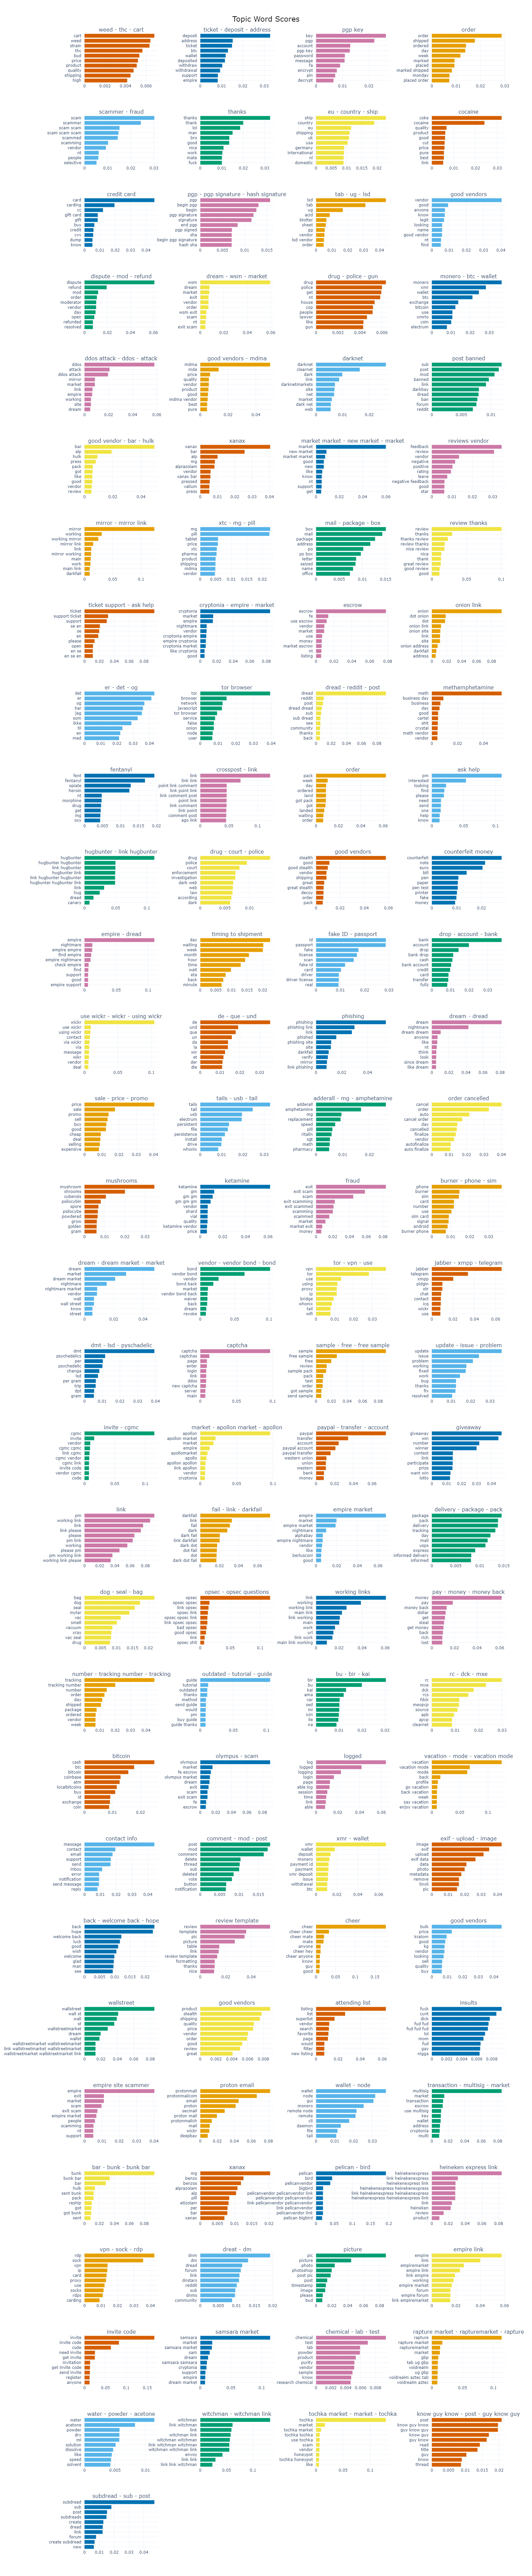
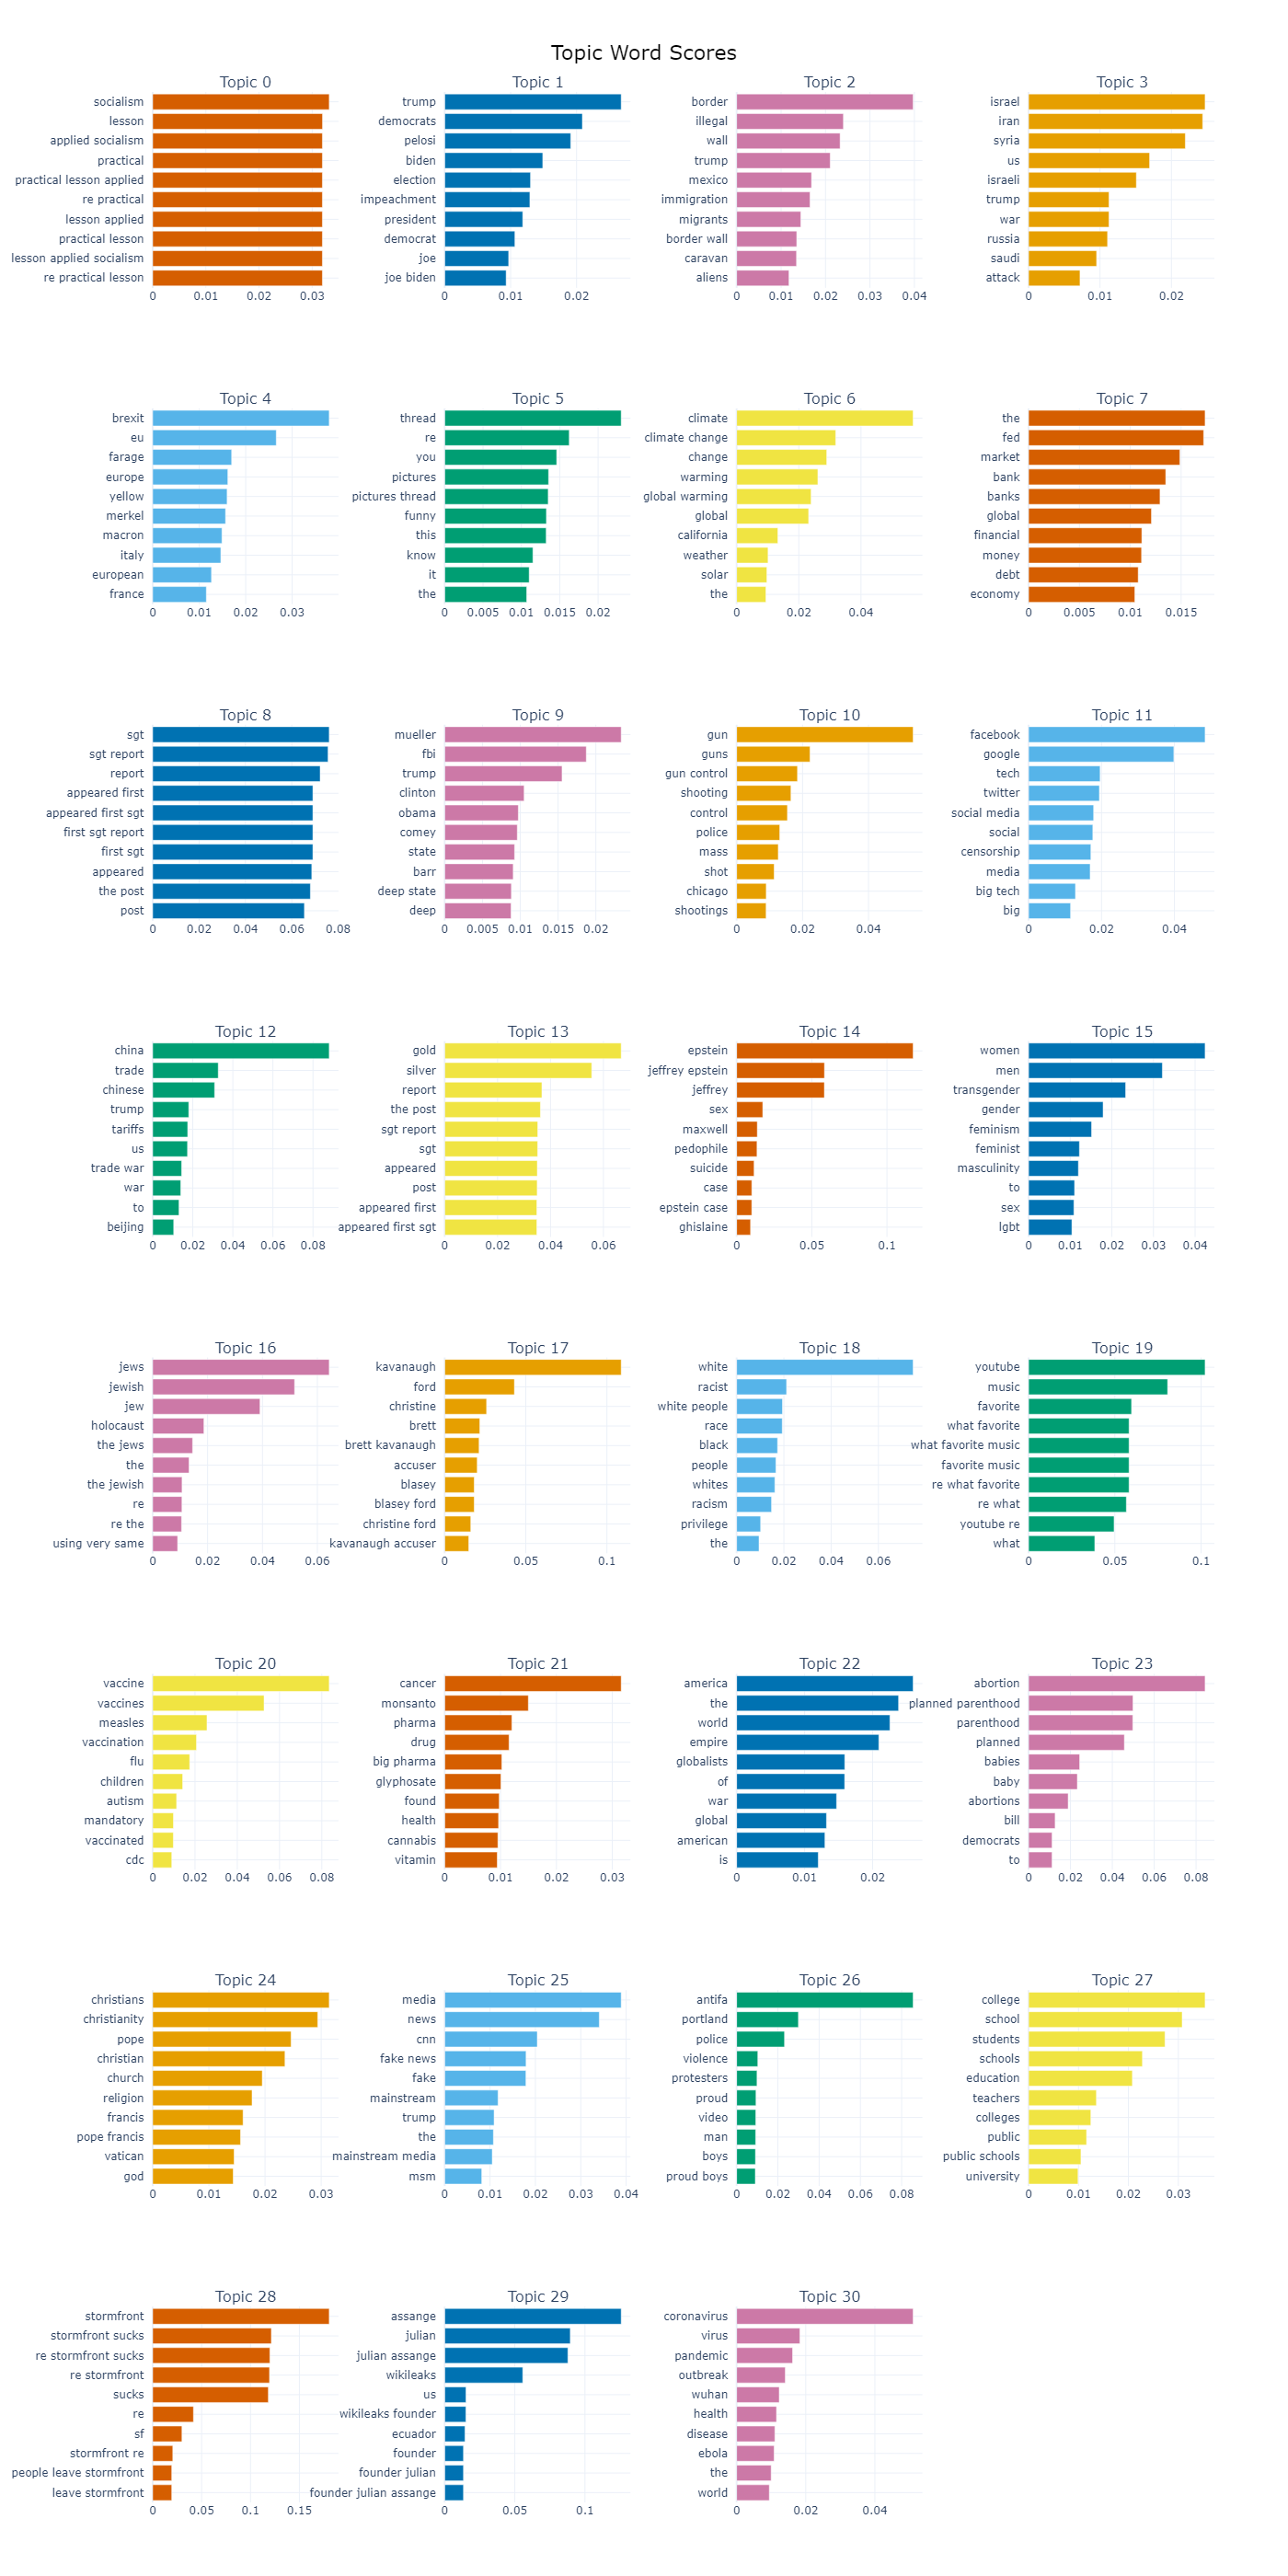
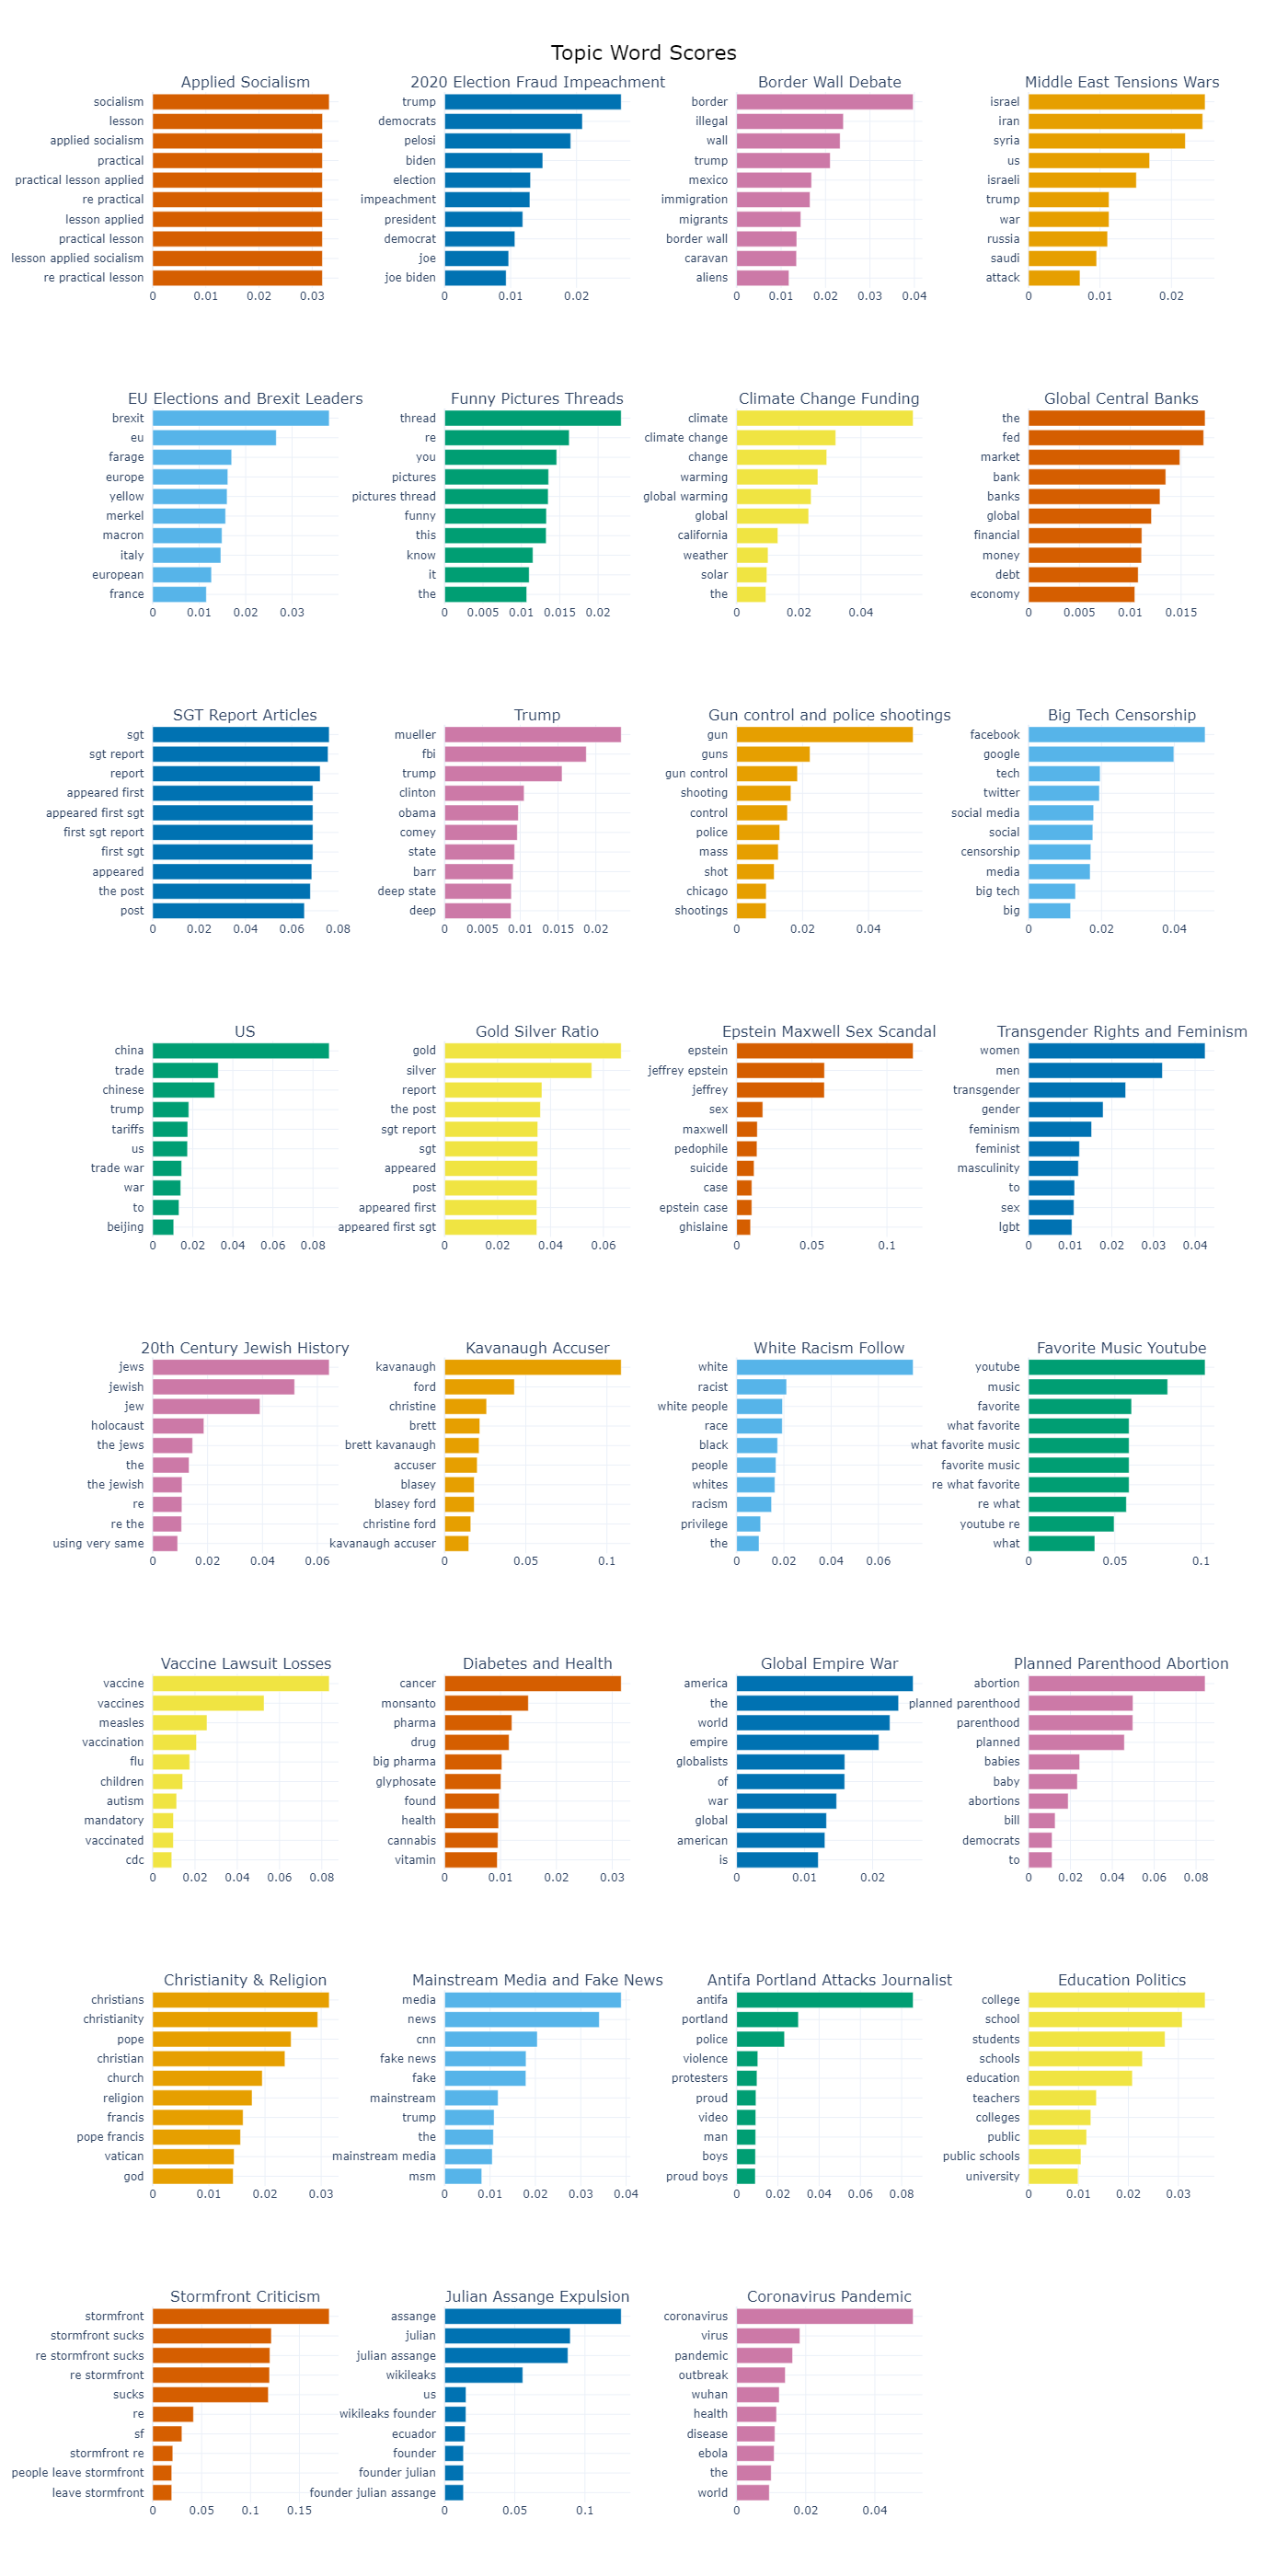
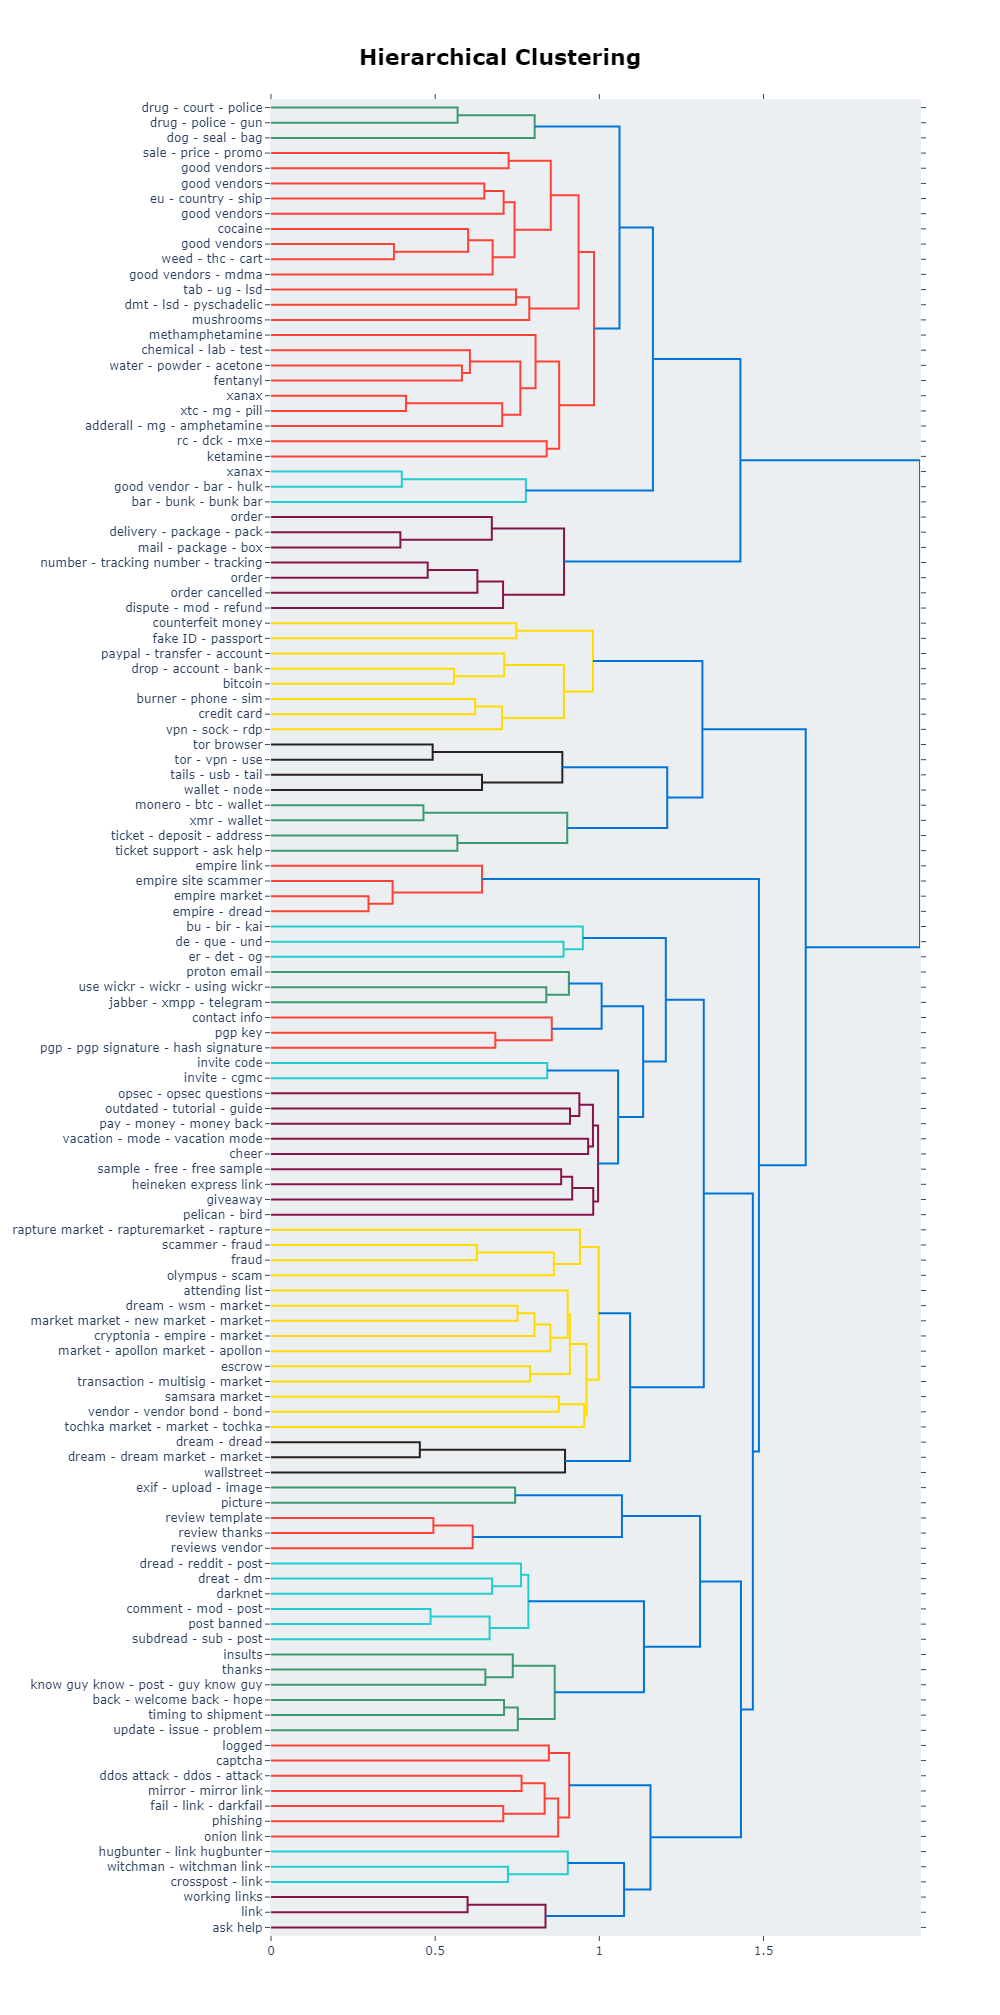

In [134]:
topic_model.visualize_hierarchy(custom_labels=True)

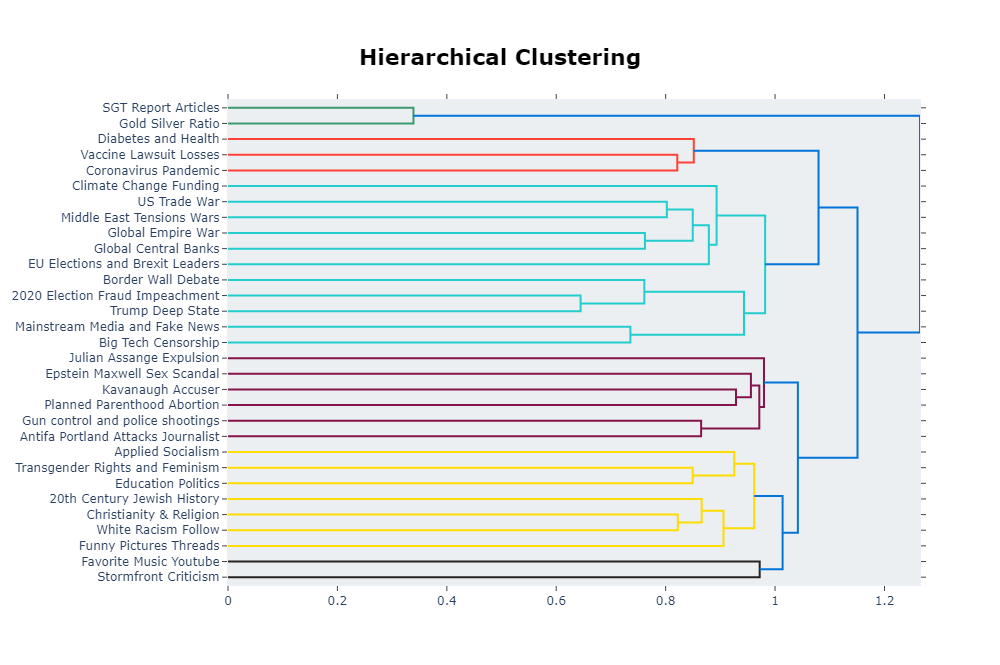
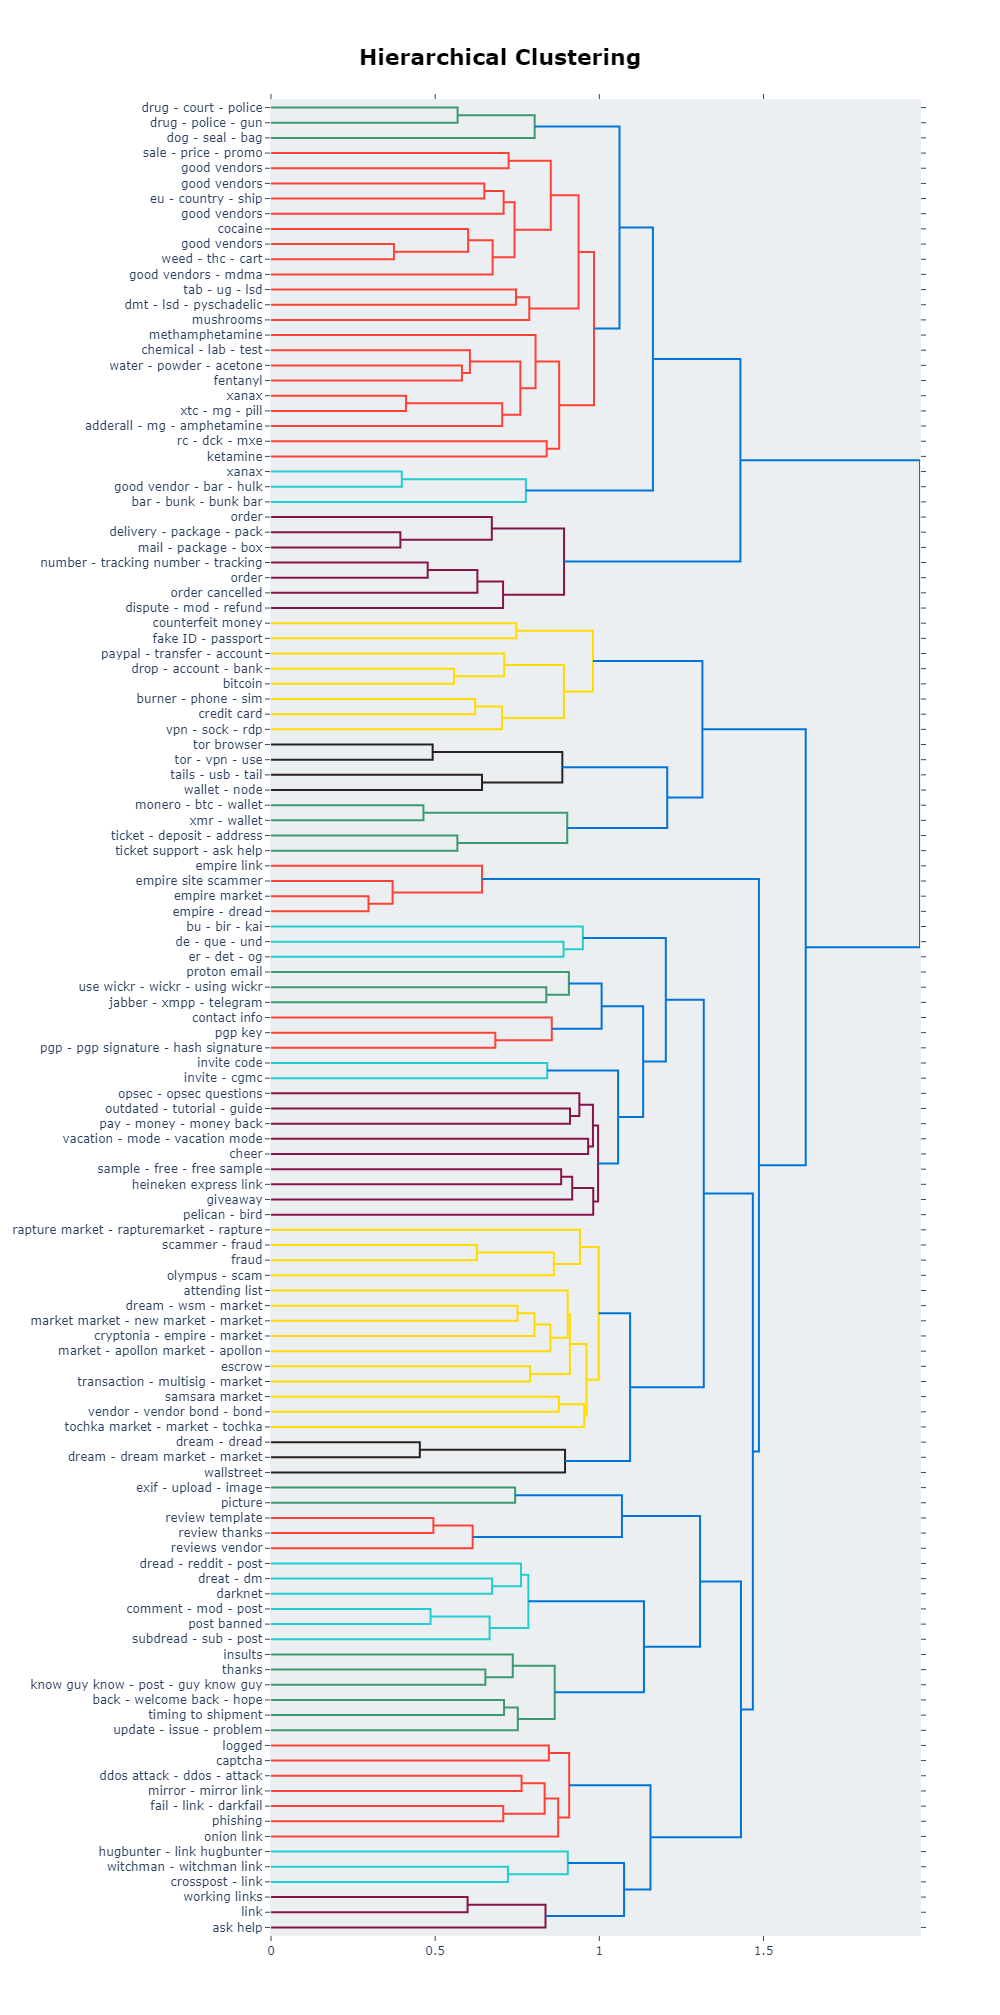
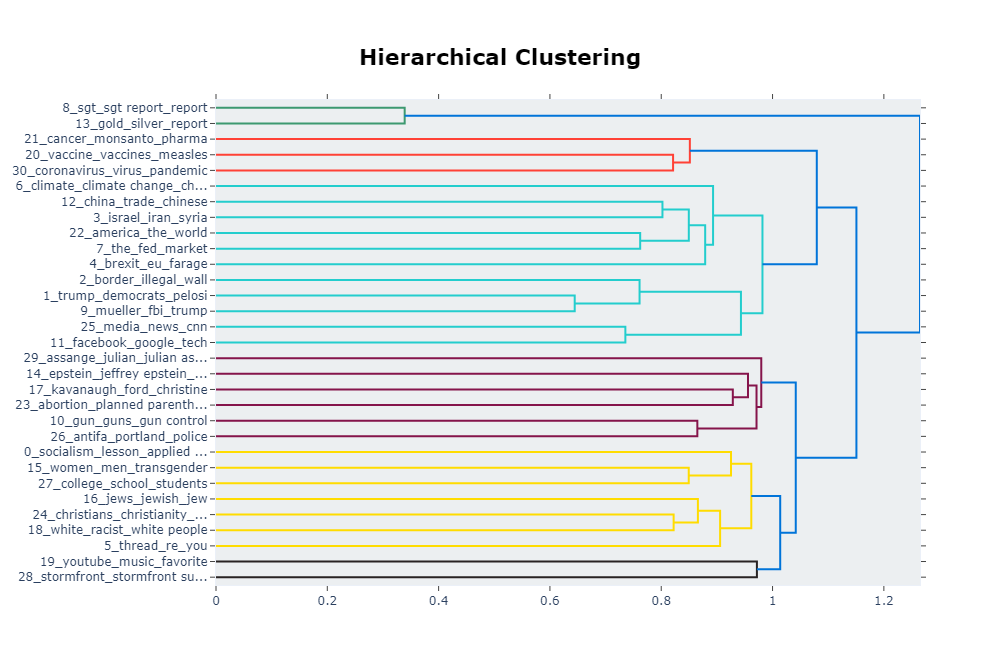
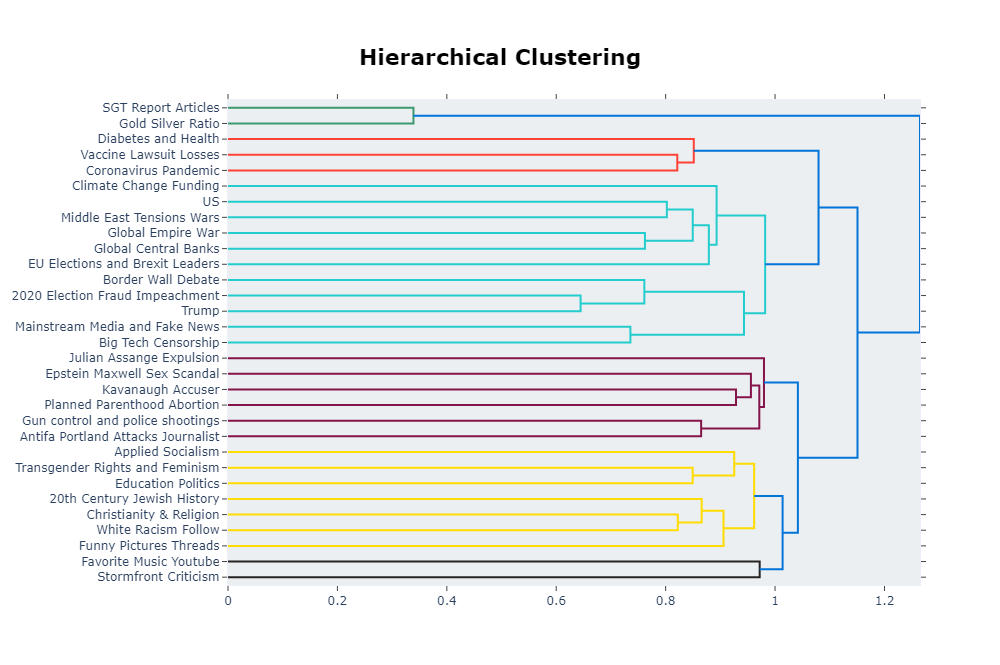
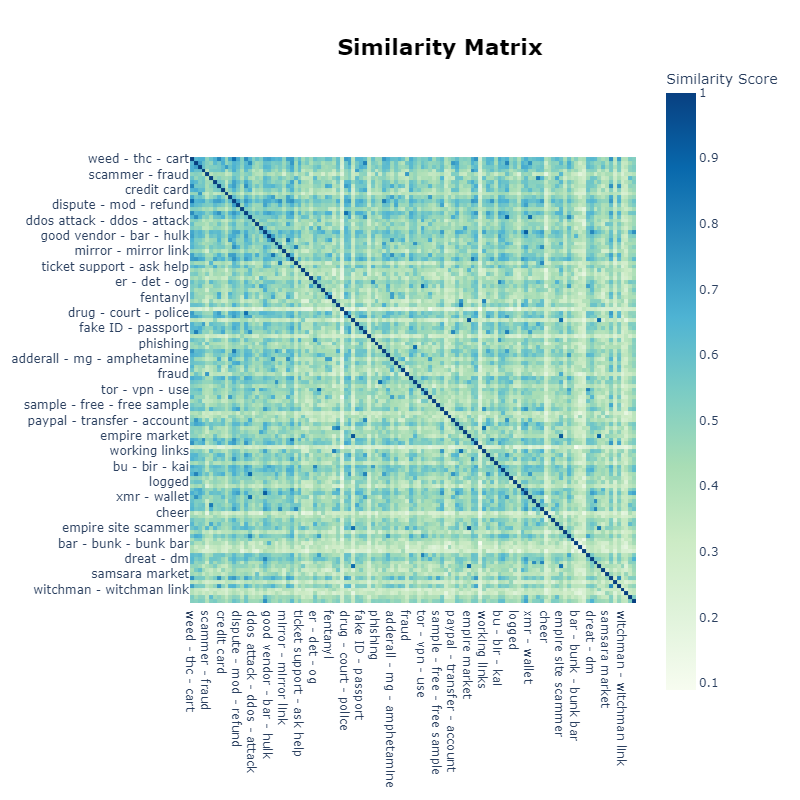

In [135]:
topic_model.visualize_heatmap(custom_labels=True)

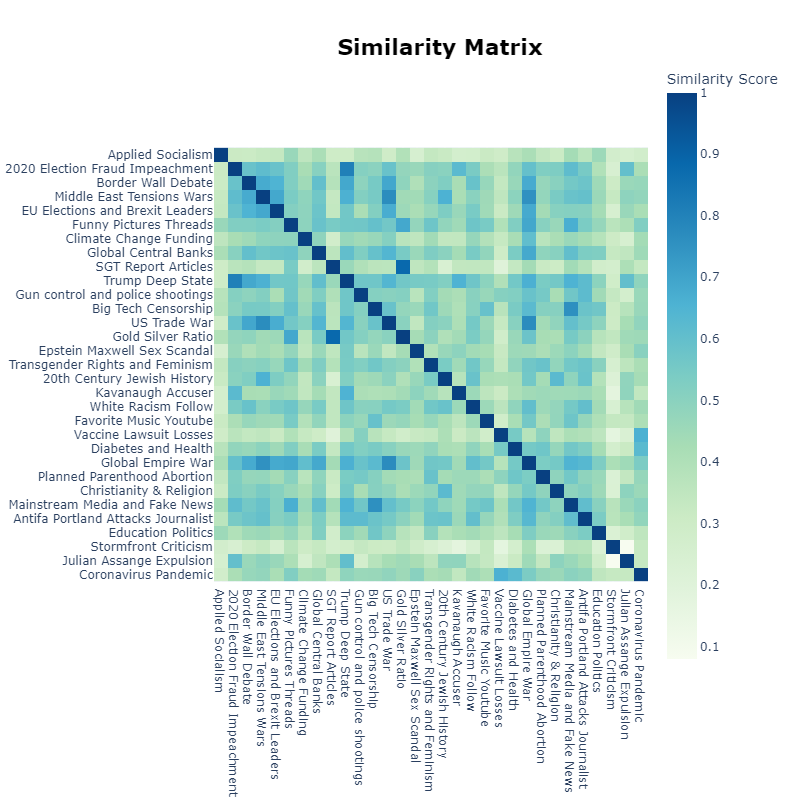
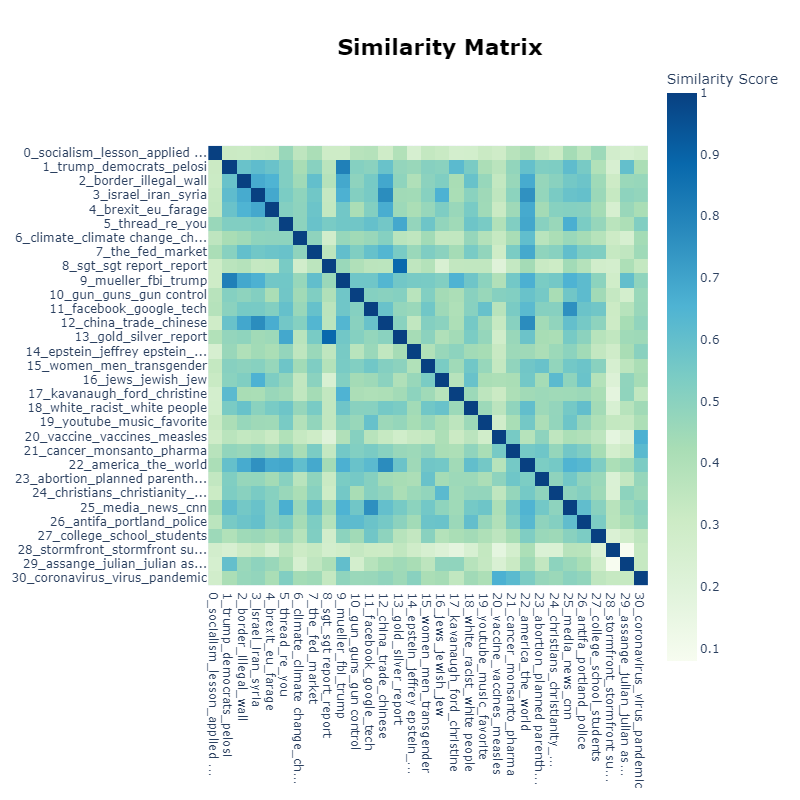
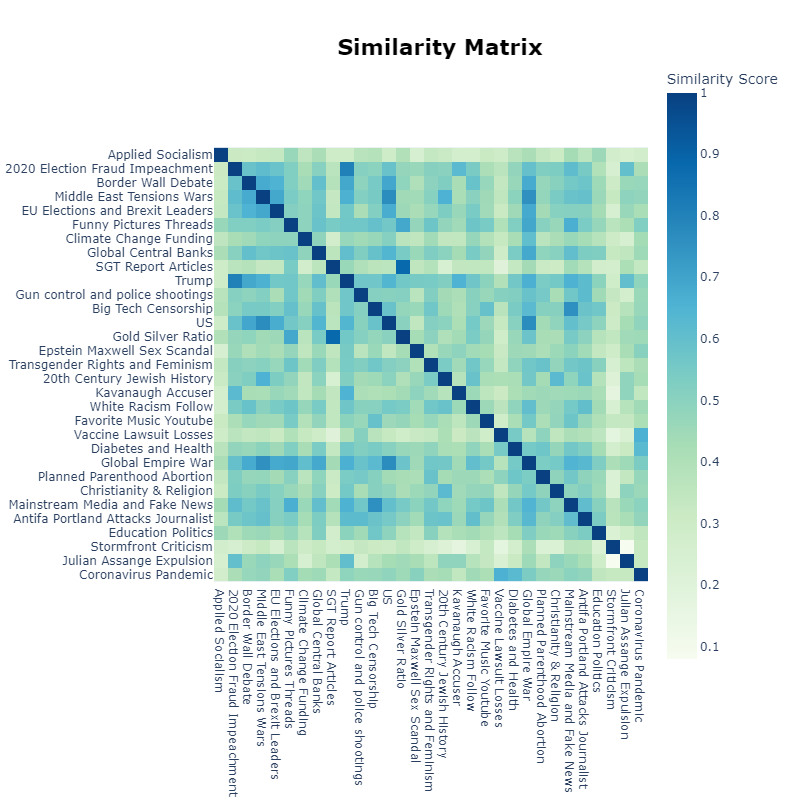
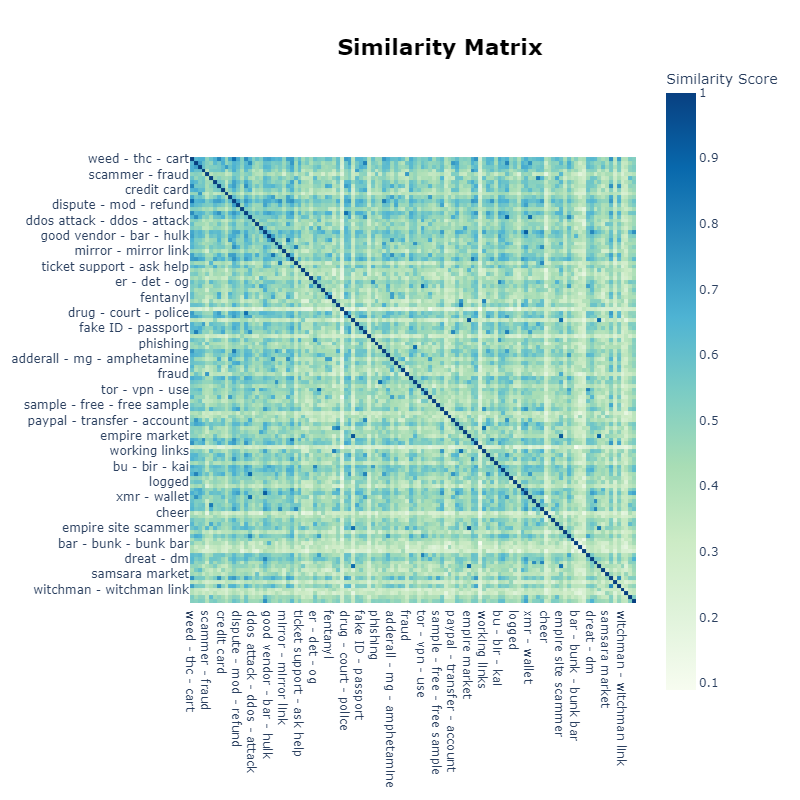

In [136]:
df = btu.load_data_filtered('../../../Datasets/CleanedData/posts_white_nation_cleaned_content_created_preprocessed.csv', 'content')
df.drop_duplicates(subset='content', inplace=True)
df.dropna(subset=['content'], inplace=True)
created_on = df['created_on'].tolist()

52310


In [137]:
topics_over_time = topic_model.topics_over_time(corpus, created_on, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=15, width=1250, height=700, custom_labels=True)

20it [02:48,  8.42s/it]


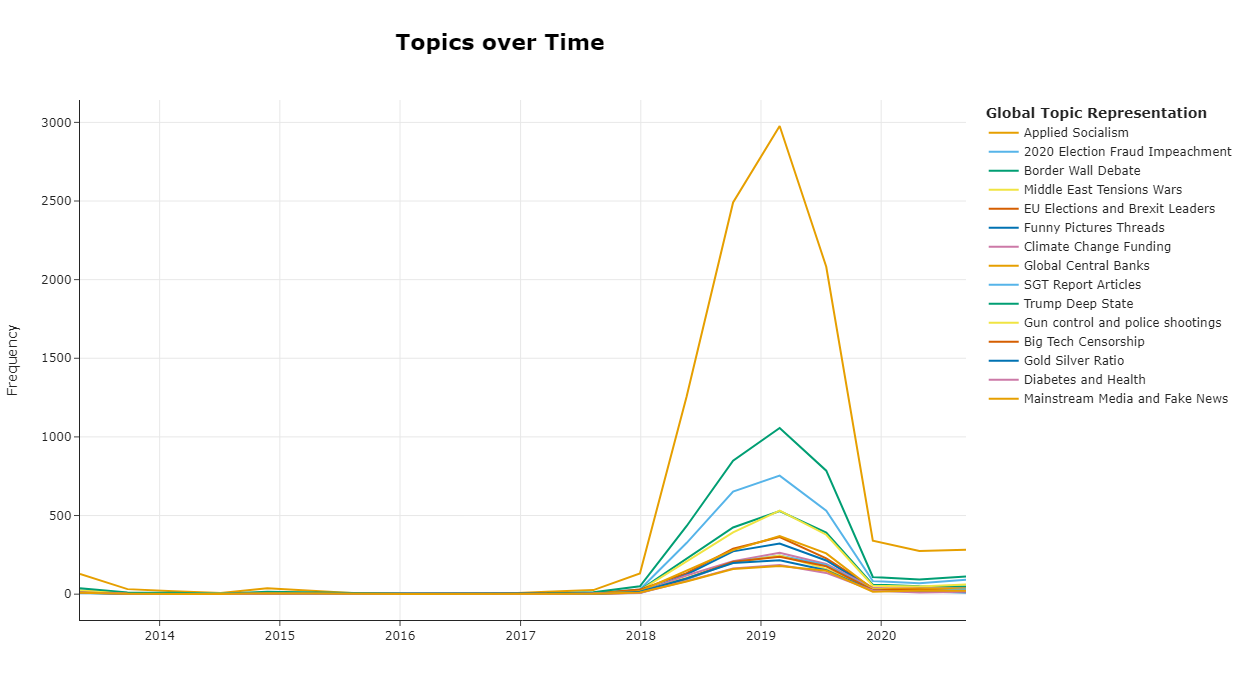
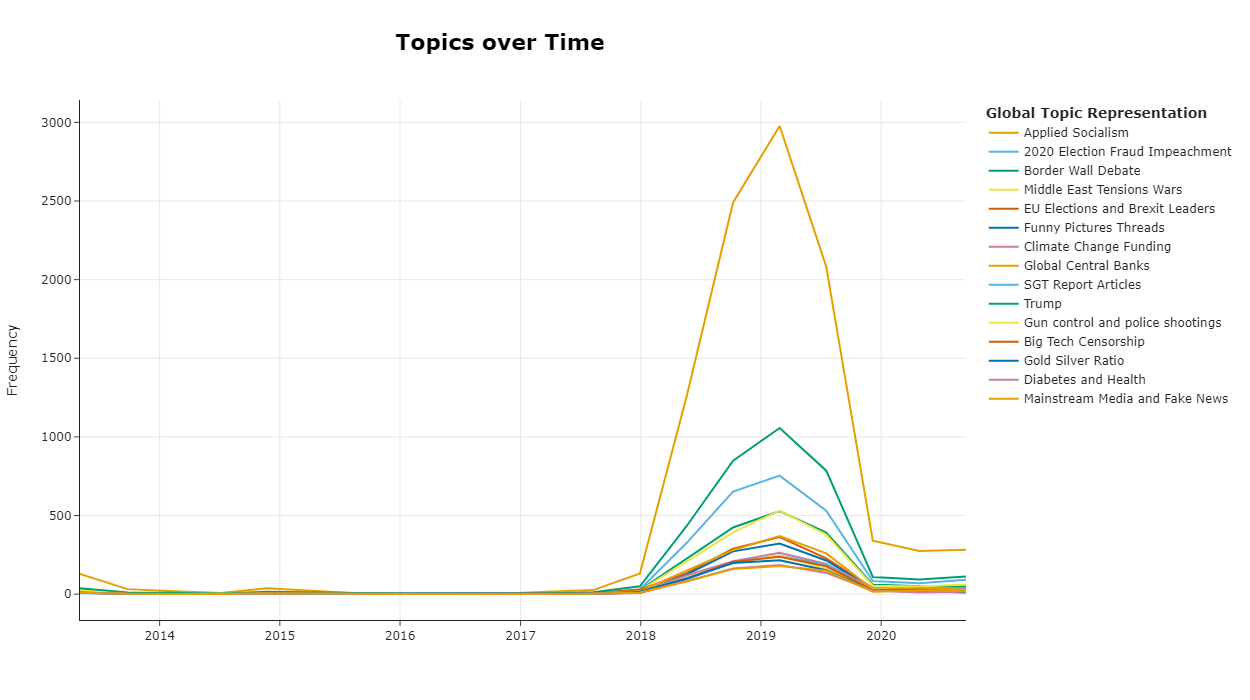
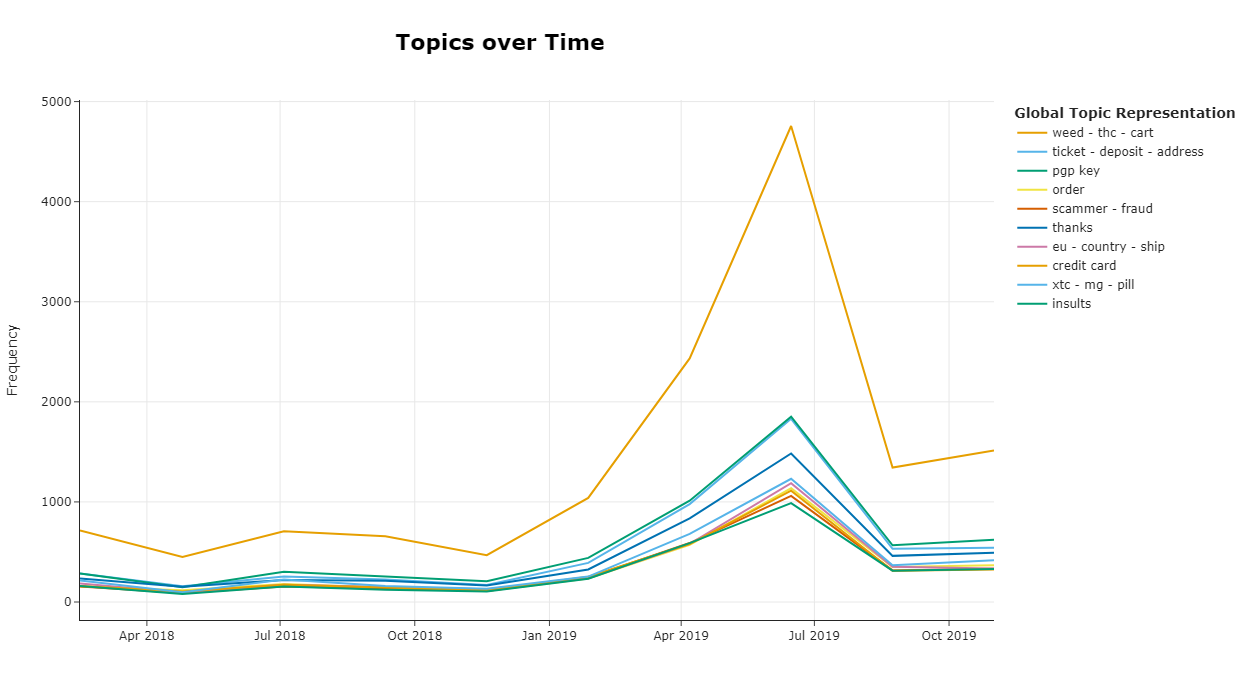

In [138]:
topics_over_time[topics_over_time['Topic'] != -1].sort_values(by=['Topic', 'Timestamp']).to_csv('DatasetsContentBERTopic/BERTopic_all-MiniLM-L6-v2_150_150n_10dim_topics_over_time_20_white_nation.csv', index=False)

In [139]:
topics_over_time = topic_model.topics_over_time(corpus, created_on, nr_bins=10)
topics_over_time[topics_over_time['Topic'] != -1].sort_values(by=['Topic', 'Timestamp']).to_csv('DatasetsContentBERTopic/BERTopic_all-MiniLM-L6-v2_150_150n_10dim_topics_over_time_10_white_nation.csv', index=False)

10it [01:51, 11.10s/it]


In [140]:
results_final = btu.return_dataset(corpus, created_on, embeddings, topic_model.topics_, probs, topic_model, umap_embeddings)
print(results_final.shape)
results_final.head()

(35509, 11)


Document  \
0  Jason Goodman loaded David Hawkins Patreon Pre...   
1  Revealed British Intel Sent Memo Warning US Of...   
2  INDICTMENTS ON HORIZON FROM SPECIAL COUNSEL AF...   
3         Trump Admin Fining Illegals Refusing Leave   
4  Even Liberal California Can handle teacher dem...   

                                           Embedding  Topic  \
0  [-0.060998008, -0.0013547407, -0.08450357, 0.0...      8   
1  [-0.07714215, -0.009344686, -0.034888353, 0.08...      9   
2  [-0.04173512, 0.018137285, -0.008506534, -0.05...      9   
3  [0.08102418, 0.029327497, -0.019253973, -0.014...      2   
4  [0.028260654, 0.0148315085, 0.02778678, 0.0731...     27   

                                         Probability  Created_on  Count  \
0  [4.3054532691231925e-308, 9.041381573968408e-3...  2018-11-05    832   
1  [0.006448335990091314, 0.028645594211870705, 0...  2018-11-09   3596   
2  [0.009922074079458106, 0.05441534983035528, 0....  2018-11-08   3596   
3  [0.020314429649521314, 0.06388780129157537, 0....  2019-05-16   1802   
4  [0.012575165264700382, 0.016945878528489892, 0...  2018-11-06    374   

                                     Name           CustomName  \
0  8_sgt_sgt report_report_appeared first  SGT Report Articles   
1             9_mueller_fbi_trump_clinton     Trump Deep State   
2             9_mueller_fbi_trump_clinton     Trump Deep State   
3             2_border_illegal_wall_trump   Border Wall Debate   
4      27_college_school_students_schools   Education Politics   

                                      Representation  \
0  [sgt, sgt report, report, appeared first, appe...   
1  [mueller, fbi, trump, clinton, obama, comey, s...   
2  [mueller, fbi, trump, clinton, obama, comey, s...   
3  [border, illegal, wall, trump, mexico, immigra...   
4  [college, school, students, schools, education...   

                                 Representative_Docs  \
0  [Mark Dice loaded It Happening The post It Hap...   
1  [True Pundit A mystery case front United State...   
2  [True Pundit A mystery case front United State...   
3  [Joe Biden planning dismantle legal wall Unite...   
4  [Campus Wokesters Expose The Descent Of Libera...   

                                      UMAP_embedding  
0  [10.019962, 8.792961, 0.32180685, 4.2927055, 7...  
1  [10.217353, 8.051011, -0.489887, 3.085789, 6.3...  
2  [10.212348, 8.0048275, -0.7482794, 2.9405718, ...  
3  [10.121845, 6.8956323, -1.2087544, 3.3809812, ...  
4  [10.153618, 5.990927, -0.25866762, 2.230345, 7...

In [143]:
results_final.to_parquet('DatasetsContentBERTopic/BERTopic_all-MiniLM-L6-v2_150_150n_10dim_white_nation.parquet')

In [144]:
topic_model.save("ModelsContent/topic_model_all-MiniLM-L6-v2_150_150n_10dim_white_nation", serialization="pickle", save_ctfidf=True, save_embedding_model=model)

2024-08-01 20:36:34,722 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [145]:
topic_model.save("ModelsContent/topic_model_all-MiniLM-L6-v2_150_150n_10dim_white_nation_safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model=model)

# Examples

In [147]:
topic_model = BERTopic.load("ModelsContent/topic_model_all-MiniLM-L6-v2_150_150n_10dim_white_nation", embedding_model='all-MiniLM-L6-v2')

In [148]:
sentence = ['conspirations']
btu.predict_topic(topic_model, sentence, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
2024-08-01 20:43:30,572 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:43:34,737 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:43:34,737 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:43:34,757 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:43:34,867 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:43:34,867 - BERTopic - Cluster - Completed ✓


Topic   Probability  \
0  [(climate, 0.05677249688199357), (climate chan...  1.750655e-01   
1  [(america, 0.025957861855601342), (the, 0.0238...  1.255862e-31   
2  [(border, 0.03971644636967441), (illegal, 0.02...  1.772883e-36   
3  [(abortion, 0.0843202302606633), (planned pare...  6.486559e-44   
4  [(mueller, 0.023352476102044262), (fbi, 0.0187...  8.058954e-48   

                         Label  \
0       Climate Change Funding   
1            Global Empire War   
2           Border Wall Debate   
3  Planned Parenthood Abortion   
4             Trump Deep State   

                                               Words       Sentence  
0  [climate, climate change, change, warming, glo...  conspirations  
1  [america, the, world, empire, globalists, of, ...  conspirations  
2  [border, illegal, wall, trump, mexico, immigra...  conspirations  
3  [abortion, planned parenthood, parenthood, pla...  conspirations  
4  [mueller, fbi, trump, clinton, obama, comey, s...  conspirations

In [149]:
btu.predict_topic(topic_model, ['pandemy'], custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]
2024-08-01 20:47:40,852 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:47:43,448 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:47:43,448 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:47:43,453 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:47:43,523 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:47:43,527 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(thread, 0.02300842307310754), (re, 0.0162357...     0.020203   
1  [(trump, 0.026758981045864254), (democrats, 0....     0.019858   
2  [(mueller, 0.023352476102044262), (fbi, 0.0187...     0.018507   
3  [(youtube, 0.10232523371936059), (music, 0.080...     0.015911   
4  [(america, 0.025957861855601342), (the, 0.0238...     0.015236   

                             Label  \
0           Funny Pictures Threads   
1  2020 Election Fraud Impeachment   
2                 Trump Deep State   
3           Favorite Music Youtube   
4                Global Empire War   

                                               Words Sentence  
0  [thread, re, you, pictures, pictures thread, f...  pandemy  
1  [trump, democrats, pelosi, biden, election, im...  pandemy  
2  [mueller, fbi, trump, clinton, obama, comey, s...  pandemy  
3  [youtube, music, favorite, what favorite, what...  pandemy  
4  [america, the, world, empire, globalists, of, ...  pandemy

In [150]:
btu.predict_topic(topic_model, ['virus'], custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
2024-08-01 20:47:56,618 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:47:58,464 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:47:58,467 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:47:58,467 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:47:58,532 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:47:58,537 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(coronavirus, 0.05107391686287775), (virus, 0...          1.0   
1  [(epstein, 0.11743330923356197), (jeffrey epst...          0.0   
2  [(trump, 0.026758981045864254), (democrats, 0....          0.0   
3  [(border, 0.03971644636967441), (illegal, 0.02...          0.0   
4  [(israel, 0.024715953727969902), (iran, 0.0243...          0.0   

                             Label  \
0             Coronavirus Pandemic   
1      Epstein Maxwell Sex Scandal   
2  2020 Election Fraud Impeachment   
3               Border Wall Debate   
4        Middle East Tensions Wars   

                                               Words Sentence  
0  [coronavirus, virus, pandemic, outbreak, wuhan...    virus  
1  [epstein, jeffrey epstein, jeffrey, sex, maxwe...    virus  
2  [trump, democrats, pelosi, biden, election, im...    virus  
3  [border, illegal, wall, trump, mexico, immigra...    virus  
4  [israel, iran, syria, us, israeli, trump, war,...    virus

In [151]:
btu.predict_topic(topic_model, ['scandal'], num_classes=3, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]
2024-08-01 20:48:16,243 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:48:18,258 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:48:18,259 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:48:18,263 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:48:18,318 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:48:18,323 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(assange, 0.1258236681252748), (julian, 0.089...     0.654764   
1  [(mueller, 0.023352476102044262), (fbi, 0.0187...     0.000032   
2  [(israel, 0.024715953727969902), (iran, 0.0243...     0.000008   

                       Label  \
0   Julian Assange Expulsion   
1           Trump Deep State   
2  Middle East Tensions Wars   

                                               Words Sentence  
0  [assange, julian, julian assange, wikileaks, u...  scandal  
1  [mueller, fbi, trump, clinton, obama, comey, s...  scandal  
2  [israel, iran, syria, us, israeli, trump, war,...  scandal

In [152]:
btu.predict_topic(topic_model, ['elections'], num_classes=1, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]
2024-08-01 20:49:21,793 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:49:24,761 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:49:24,769 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:49:24,771 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:49:24,855 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:49:24,855 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(trump, 0.026758981045864254), (democrats, 0....     0.977469   

                             Label  \
0  2020 Election Fraud Impeachment   

                                               Words   Sentence  
0  [trump, democrats, pelosi, biden, election, im...  elections

In [153]:
btu.predict_topic(topic_model, ['Eu'], num_classes=1, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]
2024-08-01 20:50:05,120 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:50:06,932 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:50:06,932 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:50:06,940 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:50:07,008 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:50:07,013 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(brexit, 0.03797234101764251), (eu, 0.0265756...      0.04062   

                             Label  \
0  EU Elections and Brexit Leaders   

                                               Words Sentence  
0  [brexit, eu, farage, europe, yellow, merkel, m...       Eu

In [155]:
btu.predict_topic(topic_model, ['Racism'], num_classes=3, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]
2024-08-01 20:54:11,753 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:54:13,328 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:54:13,328 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:54:13,362 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:54:13,484 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:54:13,484 - BERTopic - Cluster - Completed ✓


Topic  Probability  \
0  [(white, 0.07472315534093334), (racist, 0.0211...     0.327285   
1  [(college, 0.03536033687772518), (school, 0.03...     0.093827   
2  [(women, 0.04240462505747959), (men, 0.0321306...     0.027842   

                             Label  \
0              White Racism Follow   
1               Education Politics   
2  Transgender Rights and Feminism   

                                               Words Sentence  
0  [white, racist, white people, race, black, peo...   Racism  
1  [college, school, students, schools, education...   Racism  
2  [women, men, transgender, gender, feminism, fe...   Racism

In [158]:
btu.predict_topic(topic_model, ['police abuse'], num_classes=3, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]
2024-08-01 20:57:22,947 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-08-01 20:57:25,440 - BERTopic - Dimensionality - Completed ✓
2024-08-01 20:57:25,443 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-08-01 20:57:25,449 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-08-01 20:57:25,693 - BERTopic - Probabilities - Completed ✓
2024-08-01 20:57:25,695 - BERTopic - Cluster - Completed ✓


Topic   Probability  \
0  [(antifa, 0.08558154706448108), (portland, 0.0...  3.725467e-01   
1  [(gun, 0.05355233111955208), (guns, 0.02225620...  2.498225e-01   
2  [(white, 0.07472315534093334), (racist, 0.0211...  8.118123e-09   

                                Label  \
0  Antifa Portland Attacks Journalist   
1    Gun control and police shootings   
2                 White Racism Follow   

                                               Words      Sentence  
0  [antifa, portland, police, violence, protester...  police abuse  
1  [gun, guns, gun control, shooting, control, po...  police abuse  
2  [white, racist, white people, race, black, peo...  police abuse